<span style='font-family:serif'> <font size="8">  <span style='color:#0066cc'> **Stations on LLC grids**

<span style='font-family:serif'> <font size="4.5"> Some tests on `stations` sampleMethod. In particular, I want to assert that:

1. Velocity vectors are being handled correctly (correct sign and orientation).
2. C - Staggered grid is preserved.


For that, I take a look at a sample of the ECCO dataset, and create an artifucial velocity field that is purely cyclonic.

## Cyclonic velocity


Consider the case $\left[U_{E}=1, V_{N}\right]=\left[1, 0\right]$, a purely cyclonic velocity. We want to get faced velocity that produces such circulation. The transformation rule is

\begin{eqnarray}
U_{E} =& U^{[i]}\cos^{[i]}{(\theta)} -V^{[i]}\sin^{[i]}{(\theta)}\\
V_{N} =& U^{[i]}\sin^{[i]}{(\theta)} + V^{[i]}\cos^{[i]}{(\theta)}
\end{eqnarray}


where $[i]$ refers to the face index. NOTE: All variables are known, but the angle evaluations are defined on scalar points while the velocities are defined at their respective vel points (C- staggered grid). To be entirely accurate I should interpolate these onto U and V points but, for now, I am just checking if the signs and grid staggering is correct, so I will not interpolate these variables. I still should get something very close to the desired velocity field.


We can to create data arrays that, when taking into account the angles recover the observed velocity. This will serve as a check that the station `sampMethod` extracts accurate values.


WE need to solve the following system:

\begin{equation}
\begin{bmatrix}
U^{[i]}\\
V^{[i]}
\end{bmatrix}
= 
\begin{bmatrix}
\cos^{[i]*}{(\theta)} & \sin^{[i]*}{(\theta)}\\
-\sin^{[i]*}{(\theta)} & \cos^{[i]*}{(\theta)}
\end{bmatrix}
\begin{bmatrix}
1\\
0
\end{bmatrix}
\end{equation}


where the $^{[i]*}$ superscripts refers not only to the face evaluation (LLC geometry) but also to the necessary interpolation








In [1]:
import numpy as np
import xarray as xr
import copy
import oceanspy as ospy
import matplotlib.pyplot as plt

from oceanspy.llc_rearrange import mates

In [2]:
print(xr.__version__, ospy.__version__)

2023.6.0 0.2.1.dev219+g8968694


In [3]:
# Directory
ECCO_url = "catalog_ECCO.yaml"
ECCOod = ospy.open_oceandataset.from_catalog("LLC", ECCO_url)
od = ECCOod

Opening LLC.


## Single longitude / latitude stations


In [4]:
### single lat stations (76N)

ixx, iyy = np.array([10, 45, 80, 45]), np.array([45, 10, 45, 80])

lons_76N = []
lats_76N = []

for i in range(len(ixx)):
    lons_76N.append(od._ds['XC'].isel(face=6, X=ixx[i], Y=iyy[i]).values)
    lats_76N.append(od._ds['YC'].isel(face=6, X=ixx[i], Y=iyy[i]).values)


## Single Longitude stations

faces = [2, 2, 2, 6, 6, 6]
ixs = [45, 45, 45, 5, 15, 25]
iys = [65, 75, 85, 45, 45, 45]

lons_6E = []
lats_6E = []

for i in range(len(ixs)):
    lons_6E.append(od._ds['XC'].isel(face=faces[i], X=ixs[i], Y=iys[i]).values)
    lats_6E.append(od._ds['YC'].isel(face=faces[i], X=ixs[i], Y=iys[i]).values)


# some plot with desired nearest neighbors

In [5]:
colors=['#000099', '#0080FF']
markers = ['>', '*', 's', 'o']

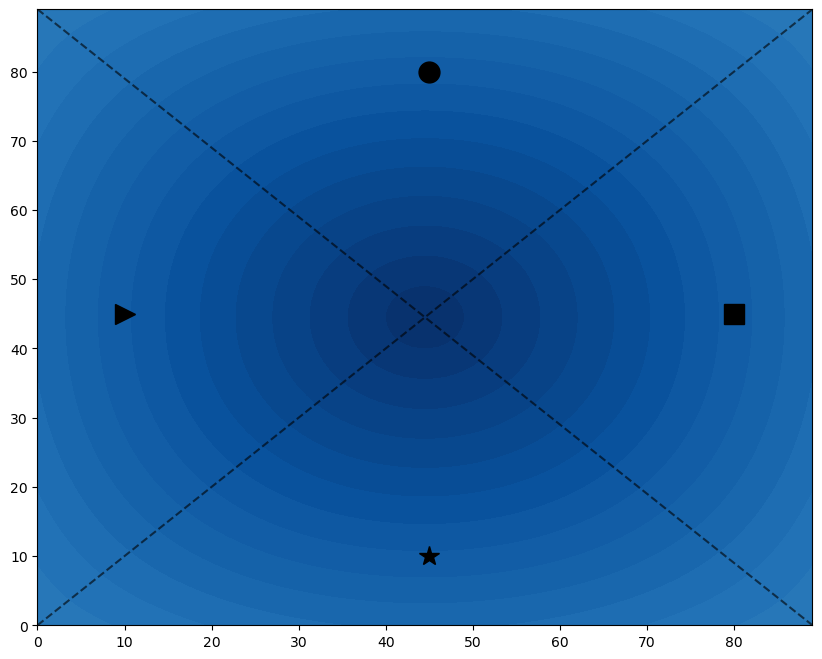

In [6]:
fig = plt.figure(figsize=(10, 8), facecolor='w')
# plt.contourf(od._ds['Depth'].isel(face=6), levels=np.linspace(0, 1000, 50), cmap='Greys_r')
plt.contourf(od._ds['YC'].isel(face=6), levels=np.linspace(10, 90, 50), cmap='Blues')
# plt.colorbar()
plt.plot(np.linspace(0, 89, 10), np.linspace(0, 89, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 89, 10), 89-np.linspace(0, 89, 10), 'k--', alpha=0.6)
plt.plot(ixx[0], iyy[0], 'k', marker=markers[0], markersize=15)
plt.plot(ixx[1], iyy[1], 'k', marker=markers[1], markersize=15);
plt.plot(ixx[2], iyy[2], 'k', marker=markers[2], markersize=15);
plt.plot(ixx[3], iyy[3], 'k', marker=markers[3], markersize=15);

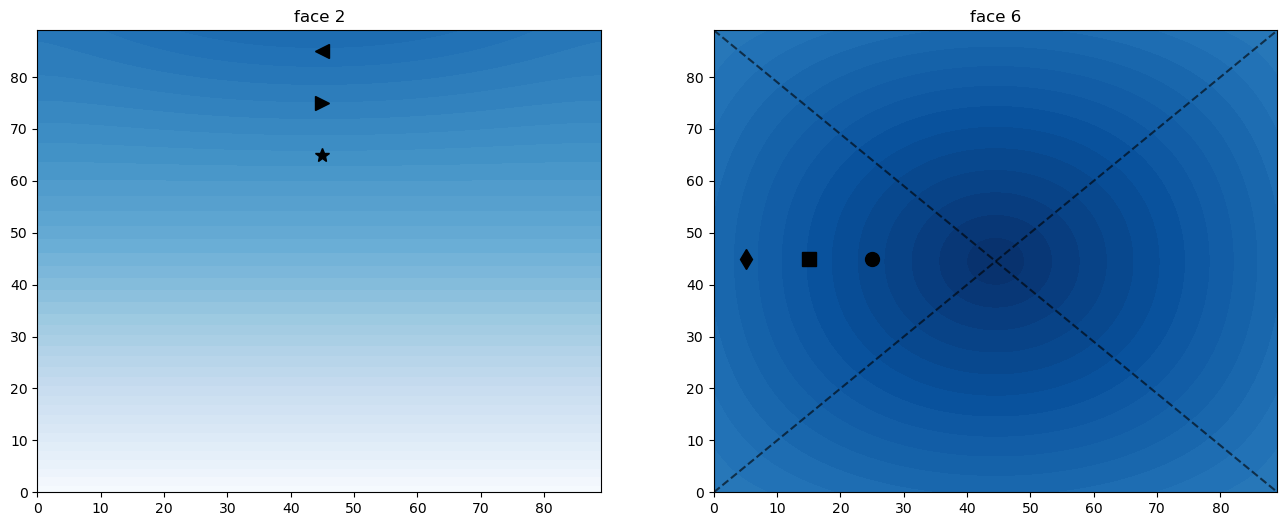

In [7]:
markers_new = ['*', '>', '<','d','s','o', ]

fig = plt.figure(figsize=(16, 6), facecolor='w')
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0])
plt.contourf(od._ds['YC'].isel(face=2), levels=np.linspace(10, 90, 50), cmap='Blues')
plt.plot(45, 65, 'k', marker='*', markersize=10);
plt.plot(45, 75, 'k', marker='>', markersize=10);
plt.plot(45, 85, 'k', marker='<', markersize=10);
plt.ylim(0, 89)
plt.title('face 2')
ax2 = fig.add_subplot(gs[1])
plt.contourf(od._ds['YC'].isel(face=6), levels=np.linspace(10, 90, 50), cmap='Blues')
plt.plot(np.linspace(0, 89, 10), np.linspace(0, 89, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 89, 10), 89-np.linspace(0, 89, 10), 'k--', alpha=0.6)
plt.plot(5, 45, 'k', marker='d', markersize=10);
plt.plot(15, 45, 'k', marker='s', markersize=10);
plt.plot(25, 45, 'k', marker='o', markersize=10);
plt.title('face 6');

# Cyclonic velocity calculation


This is semi-accurate

In [8]:
co_list = [var for var in od._ds.coords if var not in od._ds.dims]
_ds = od._ds.reset_coords()

## create velocity field

In [9]:
nU = copy.deepcopy(_ds['CS'].values)
nV = -copy.deepcopy(_ds['SN'].values)

Ucoords = {
    'face': _ds.face.values,
    'Y': _ds.Y.values,
    'Xp1': _ds.Xp1.values, 
}

Vcoords = {
    'face': _ds.face.values,
    'Yp1': _ds.Yp1.values,
    'X': _ds.X.values, 
}

_ds['UVELMASS'] = xr.DataArray(nU, coords=Ucoords, dims=['face', 'Y', 'Xp1'])
_ds['VVELMASS'] = xr.DataArray(nV, coords=Vcoords, dims=['face', 'Yp1', 'X'])


_ds = mates(_ds.set_coords(co_list))

od._ds = _ds


# visualize

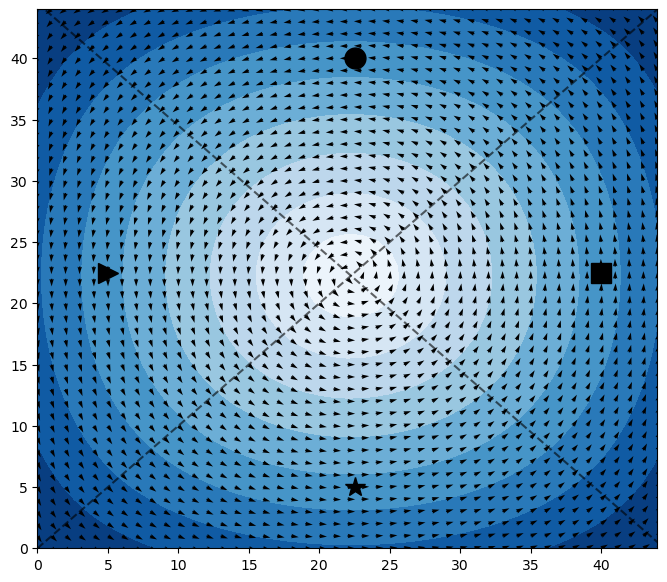

In [10]:
fig = plt.figure(figsize=(8, 7), facecolor='w')
plt.contourf(od._ds['YC'].isel(face=6)[::2, ::2], levels=np.linspace(67.5, 90, 10), cmap='Blues_r')
plt.quiver(od._ds['UVELMASS'].isel(face=6)[::2, ::2], od._ds['VVELMASS'].isel(face=6)[::2, ::2]);
plt.plot(np.linspace(0, 44.5, 10), np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 44.5, 10), 44.5-np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.plot(ixx[0]/2, iyy[0]/2, 'k', marker=markers[0], markersize=15)
plt.plot(ixx[1]/2, iyy[1]/2, 'k', marker=markers[1], markersize=15);
plt.plot(ixx[2]/2, iyy[2]/2, 'k', marker=markers[2], markersize=15);
plt.plot(ixx[3]/2, iyy[3]/2, 'k', marker=markers[3], markersize=15);

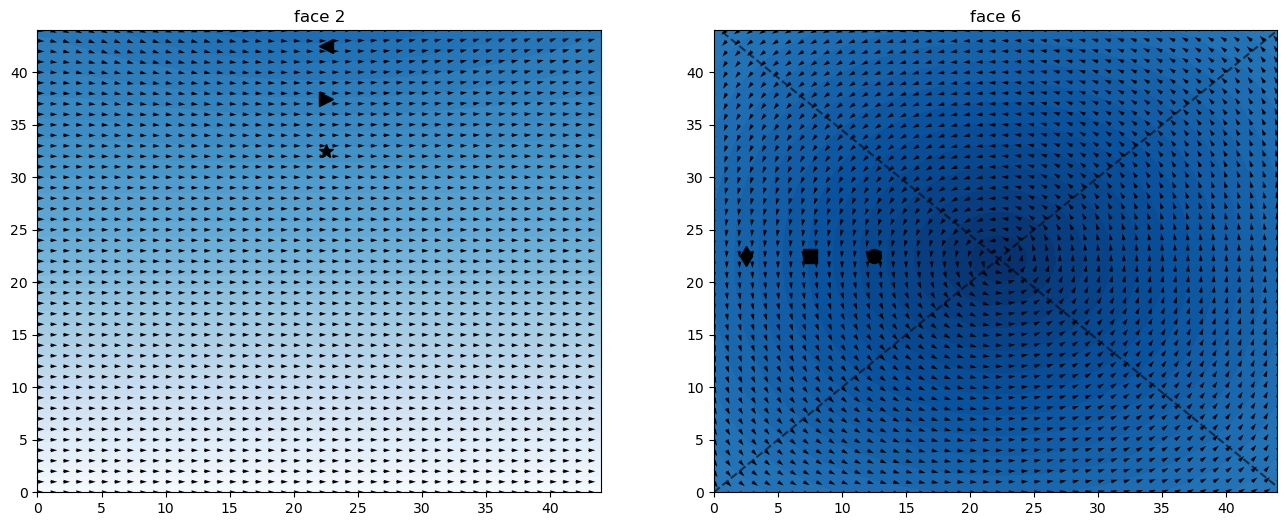

In [11]:
markers_new = ['*', '>', '<','d','s','o', ]

fig = plt.figure(figsize=(16, 6), facecolor='w')
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0])
plt.contourf(od._ds['YC'].isel(face=2)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=2)[::2, ::2], od._ds['VVELMASS'].isel(face=2)[::2, ::2]);

plt.plot(45/2, 65/2, 'k', marker='*', markersize=10);
plt.plot(45/2, 75/2, 'k', marker='>', markersize=10);
plt.plot(45/2, 85/2, 'k', marker='<', markersize=10);
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.title('face 2')
ax2 = fig.add_subplot(gs[1])
plt.contourf(od._ds['YC'].isel(face=6)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=6)[::2, ::2], od._ds['VVELMASS'].isel(face=6)[::2, ::2]);
plt.plot(np.linspace(0, 44.5, 10), np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 44.5, 10), 44.5-np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.plot(5/2, 45/2, 'k', marker='d', markersize=10);
plt.plot(15/2, 45/2, 'k', marker='s', markersize=10);
plt.plot(25/2, 45/2, 'k', marker='o', markersize=10);
plt.title('face 6');

# Stations across the North Atlantic

In [12]:
p=[{"type":"Point","coordinates":[-39.05481151032802,49.148182344281935]},{"type":"Point","coordinates":[-41.36769261284706,48.556348747481366]},{"type":"Point","coordinates":[-42.65262655869097,46.65061953371659]},{"type":"Point","coordinates":[-42.65262655869097,41.86937828918002]},{"type":"Point","coordinates":[-41.62467940201584,34.8253018629576]},{"type":"Point","coordinates":[-35.45699646196506,38.73449125129926]},{"type":"Point","coordinates":[-30.959727651511365,33.65689272953311]},{"type":"Point","coordinates":[-26.33396544647326,38.634189174007446]},{"type":"Point","coordinates":[-22.09368342518836,36.288699983098]},{"type":"Point","coordinates":[-21.32272305768201,41.0024199325517]},{"type":"Point","coordinates":[-30.31726067858941,42.44090828314131]},{"type":"Point","coordinates":[-35.58548985654945,45.49180909068974]},{"type":"Point","coordinates":[-33.4011021486148,49.315993610524]},{"type":"Point","coordinates":[-26.84793902481084,45.94038509073192]},{"type":"Point","coordinates":[-25.30601828979814,48.556348747481366]},{"type":"Point","coordinates":[-21.451216452266404,44.67529627981841]}]

lons_NA, lats_NA = ospy.utils.viewer_to_range(p)


extracting Point


In [13]:
cutout_args = {
    "YRange": [np.min(lats_NA), np.max(lats_NA)], 
    "XRange": [np.min(lons_NA), np.max(lons_NA)],
    'ZRange': 0,
    "add_Hbdr": True
}
cut_od = od.subsample.cutout(**cutout_args)

Cutting out the oceandataset.
faces in the cutout [2, 10]


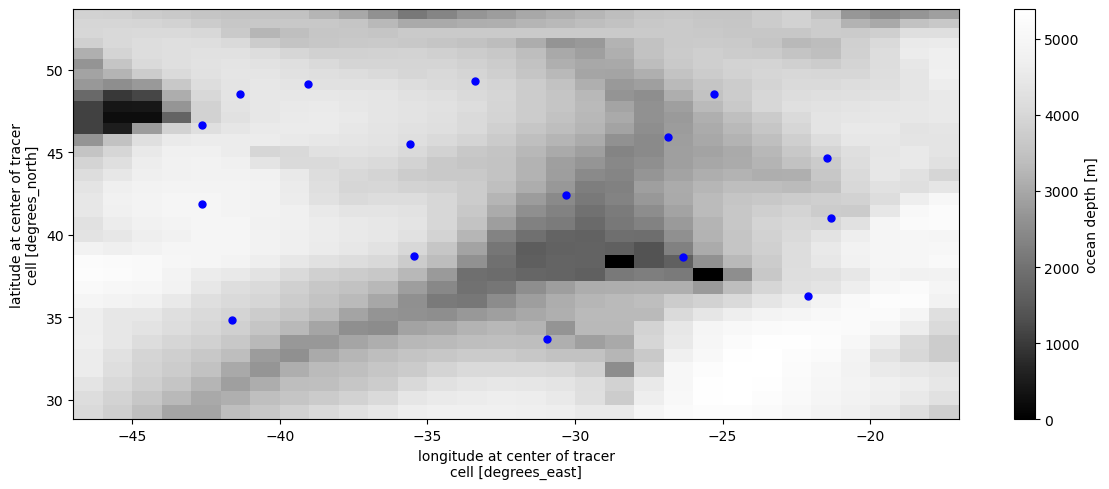

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = cut_od.plot.horizontal_section(varName="Depth", cmap='Greys_r')
ax.plot(lons_NA, lats_NA, "b", lw=3, ls='', marker='o', markersize=5)
plt.show()

## velocity field

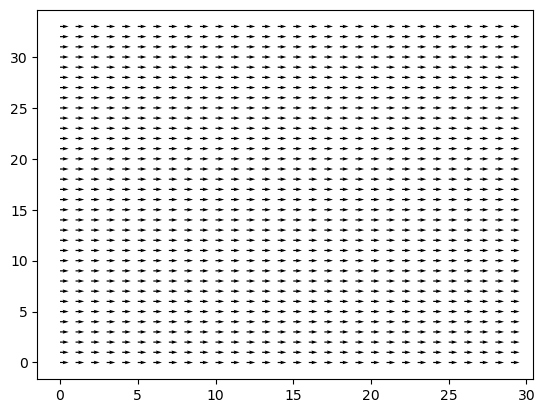

In [15]:
plt.quiver(cut_od._ds['UVELMASS'].isel(Xp1=slice(0, -1)), cut_od._ds['VVELMASS'].isel(Yp1=slice(0, -1)))

# A complex, multi-basin pathway

<img src="complex_array.png" alt="drawing" width="500"/>    

In [16]:
pc = [{"type":"LineString","coordinates":[[-157.58510458895236,-49.929113472333654],[-158.3335453373931,-56.4180474136013],[-157.58510458895236,-66.9491001967596],[-127.64747465132241,-65.43909170451556],[-104.82003182387959,-66.9491001967596],[-76.75350375735152,-64.48901164230372],[-59.91358691743467,-59.9649368160756],[-49.06119606504382,-59.77709811839834],[-49.06119606504382,-67.09518612687597],[-40.82834783219558,-73.04637258315987],[-2.283649287497039,-67.38473350379634],[22.78911578526804,-66.05394012511698],[49.732982729134996,-63.504730811017126],[78.9221719183242,-62.311936937237796],[102.52851624436076,-61.26497563498257],[119.36843308427763,-59.222724692731425],[120.1168738327184,-52.52506277528884],[114.50356821941274,-45.9407502581646],[90.55346426930878,-41.340346963740906],[57.99629171213625,-37.88205039129804],[30.303984019828572,-37.5860952909328],[-17.222003506158956,-35.481526087073114],[-41.17210745626293,-43.549163986078796],[-53.147159431314876,-52.978067922480726],[-61.7542280383835,-56.43483466663744],[-70.73551701967247,-57.85575305946762],[-87.20121348536895,-51.371854559255056],[-81.21368749784294,-39.92040864793066],[-84.20745049160595,-22.77515385083268],[-106.6606729448284,1.2986691385364821],[-131.35921764337309,21.715726006363894],[-154.5608808450363,20.669007174659797],[-157.92886421301966,-8.400687880491319],[-169.90391618807166,-25.50672614934794],[-167.28437356852905,-39.05399570881964],[-157.55464383879928,-42.454492348945855],[-157.55464383879928,-50.427847608420734]]}]

lons_c, lats_c = ospy.utils.viewer_to_range(pc)


extracting LineString


In [17]:
cutout_args = {
    "YRange": lats_c, 
    "XRange": lons_c,
    'ZRange': 0,
    "add_Hbdr": True
}
cut_od = od.subsample.cutout(**cutout_args)

Cutting out the oceandataset.
faces in the cutout [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]


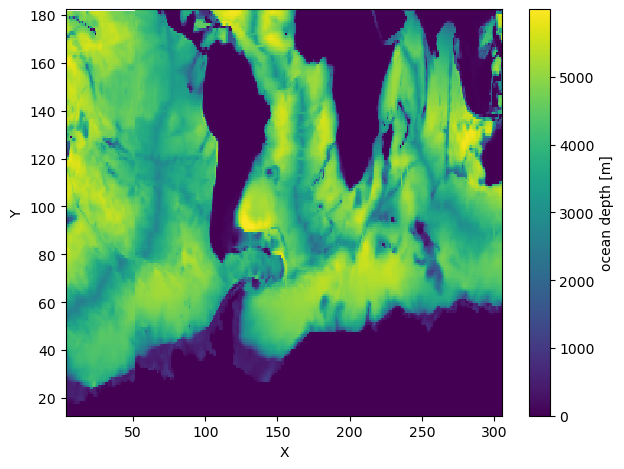

In [18]:
cut_od.plot.horizontal_section(varName='Depth', use_coords=False);

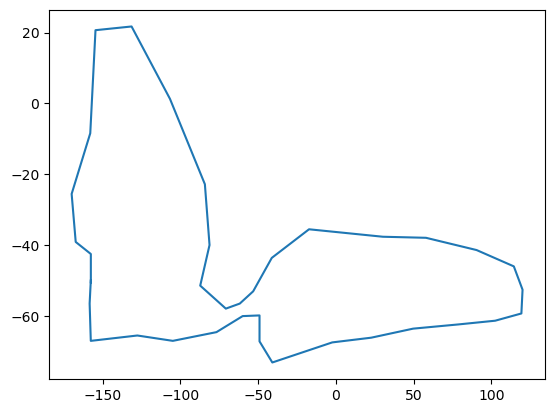

In [19]:
plt.plot(lons_c, lats_c)

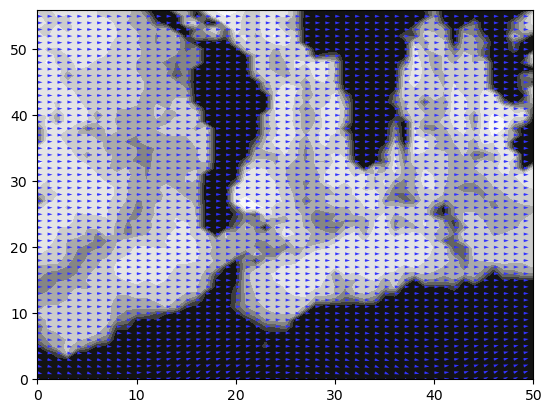

In [20]:
plt.contourf(cut_od._ds['Depth'].isel(X=slice(0, -1, 6), Y=slice(0, -1, 3)), cmap='Greys_r')
plt.quiver(cut_od._ds['UVELMASS'].isel(Xp1=slice(0, -1, 6), Y=slice(0, -1, 3)), cut_od._ds['VVELMASS'].isel(X=slice(0, -1, 6), Yp1=slice(0, -1, 3)), color='#3333FF')
plt.show()

# Extract Stations 

In [21]:
args_76N = {
    "Ycoords": lats_76N, 
    "Xcoords": lons_76N,
}
od_stns76N = od.subsample.stations(**args_76N)

Extracting stations.


In [22]:
args_7E = {
    "Ycoords": lats_6E, 
    "Xcoords": 7.5*np.ones(np.shape(lats_6E)),
}
od_stns7E = od.subsample.stations(**args_7E)

Extracting stations.


In [23]:
args_NA = {
    "Ycoords": lats_NA, 
    "Xcoords": lons_NA,
}
od_stnsNA = od.subsample.stations(**args_NA)

Extracting stations.


In [24]:
args_c = {
    "Ycoords": lats_c, 
    "Xcoords": lons_c,
}
od_stnsC = od.subsample.stations(**args_c)

Extracting stations.


In [25]:
XC76N, YC76N = od_stns76N._ds.XC, od_stns76N._ds.YC
XG76N, YG76N = od_stns76N._ds.XG, od_stns76N._ds.YG

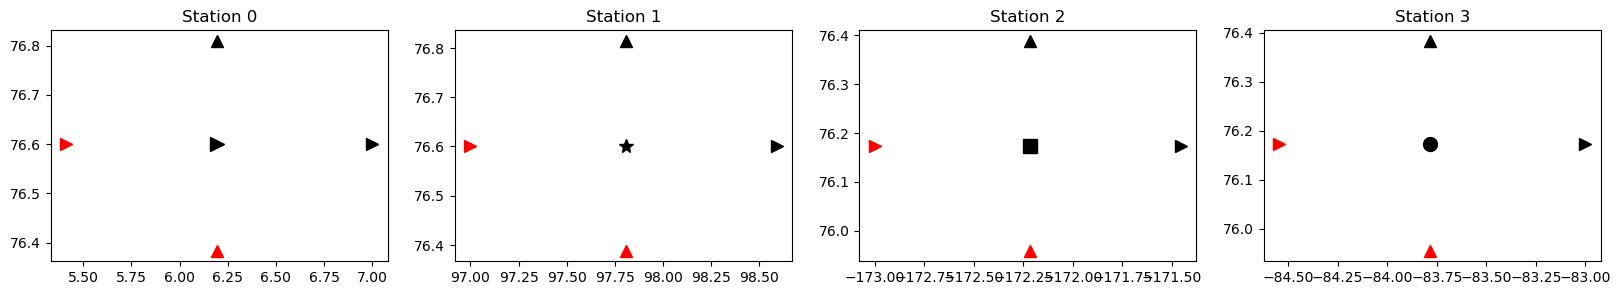

In [26]:
# point 5
fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC76N.squeeze()))
for i in range(len(XC76N.squeeze())):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XC76N.isel(station=i).values, YC76N.isel(station=i), 'k', ls='',  marker=markers[i], markersize=10)
    plt.plot(XG76N.isel(station=i, Xp1=0, Yp1=0), YC76N.isel(station=i), 'r', ls='',marker='>', markersize=8)
    plt.plot(XG76N.isel(station=i, Xp1=1, Yp1=0), YC76N.isel(station=i), 'k',ls='',marker='>', markersize=8)
    plt.plot(XC76N.isel(station=i), YG76N.isel(station=i,Xp1=0, Yp1=0), 'r',ls='',marker='^', markersize=8)
    plt.plot(XC76N.isel(station=i), YG76N.isel(station=i,Xp1=0, Yp1=1), 'k',ls='',marker='^', markersize=8)
    plt.title('Station '+str(i))

plt.show()

# Visualize velocity vectors

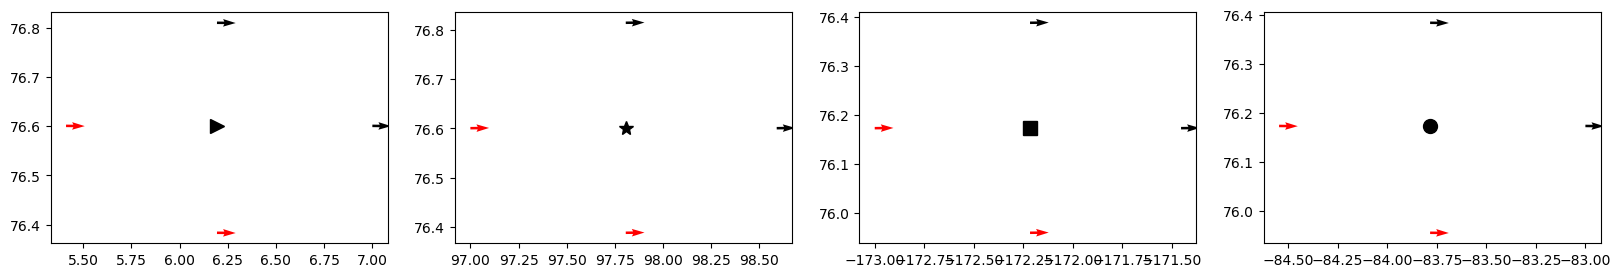

In [27]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC76N.squeeze()))
for i in range(len(XC76N.squeeze())):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XC76N.isel(station=i).values, YC76N.isel(station=i), 'k', ls='',  marker=markers[i], markersize=10)
    plt.quiver(XG76N.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YC76N.isel(station=i), od_stns76N._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns76N._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XG76N.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YC76N.isel(station=i), od_stns76N._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns76N._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XC76N.isel(station=i), YG76N.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stns76N._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns76N._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XC76N.isel(station=i), YG76N.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stns76N._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns76N._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


In [28]:
XC7E, YC7E = od_stns7E._ds.XC, od_stns7E._ds.YC
XG7E, YG7E = od_stns7E._ds.XG, od_stns7E._ds.YG

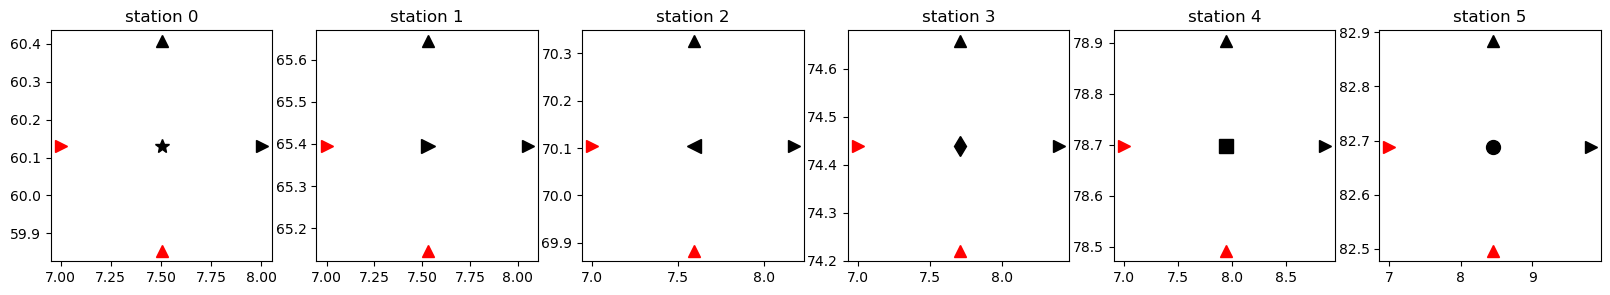

In [29]:
# point 5
fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC7E))
for i in range(len(XC7E)):
    ax = fig.add_subplot(gs[i])
    plt.plot(XC7E.isel(station=i).values, YC7E.isel(station=i), 'k', ls='',  marker=markers_new[i], markersize=10)
    plt.plot(XG7E.isel(station=i, Xp1=0, Yp1=0), YC7E.isel(station=i), 'r', ls='',marker='>', markersize=8)
    plt.plot(XG7E.isel(station=i, Xp1=1, Yp1=0), YC7E.isel(station=i), 'k',ls='',marker='>', markersize=8)
    plt.plot(XC7E.isel(station=i), YG7E.isel(station=i,Xp1=0, Yp1=0), 'r',ls='',marker='^', markersize=8)
    plt.plot(XC7E.isel(station=i), YG7E.isel(station=i,Xp1=0, Yp1=1), 'k',ls='',marker='^', markersize=8)
    plt.title('station '+str(i))
plt.show()

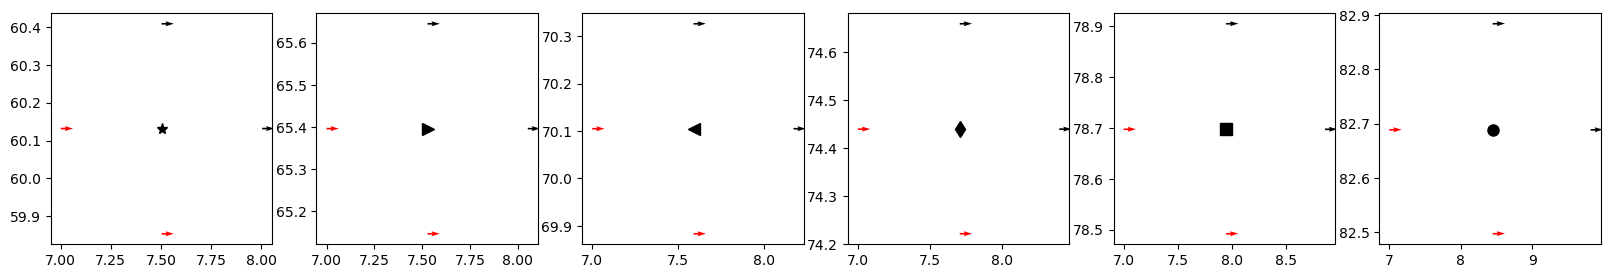

In [30]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC7E))
for i in range(len(XC7E.squeeze())):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XC7E.isel(station=i).values, YC7E.isel(station=i), 'k', ls='',  marker=markers_new[i],  markersize=8)
    plt.quiver(XG7E.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YC7E.isel(station=i), od_stns7E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns7E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XG7E.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YC7E.isel(station=i), od_stns7E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns7E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XC7E.isel(station=i), YG7E.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stns7E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns7E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XC7E.isel(station=i), YG7E.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stns7E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns7E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


In [31]:
XCNA, YCNA = od_stnsNA._ds.XC, od_stnsNA._ds.YC
XGNA, YGNA = od_stnsNA._ds.XG, od_stnsNA._ds.YG

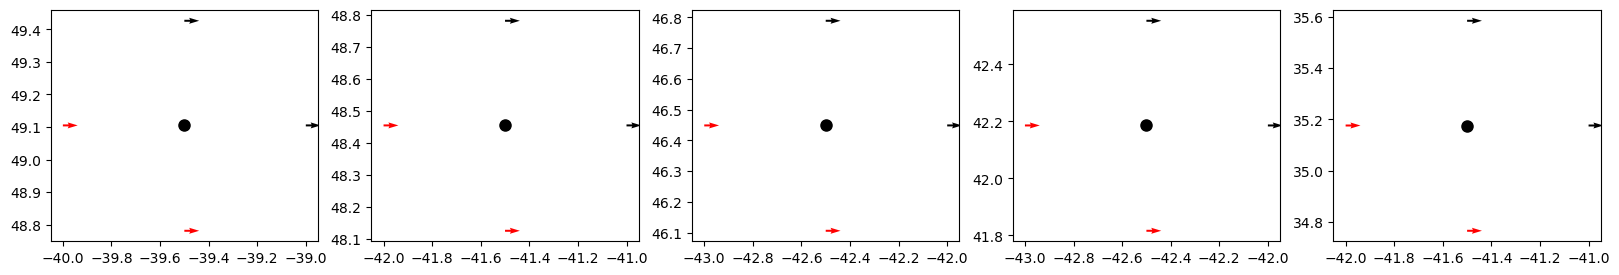

In [32]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
# for i in range(len(XCNA.squeeze())):
for i in range(5):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XCNA.isel(station=i).values, YCNA.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


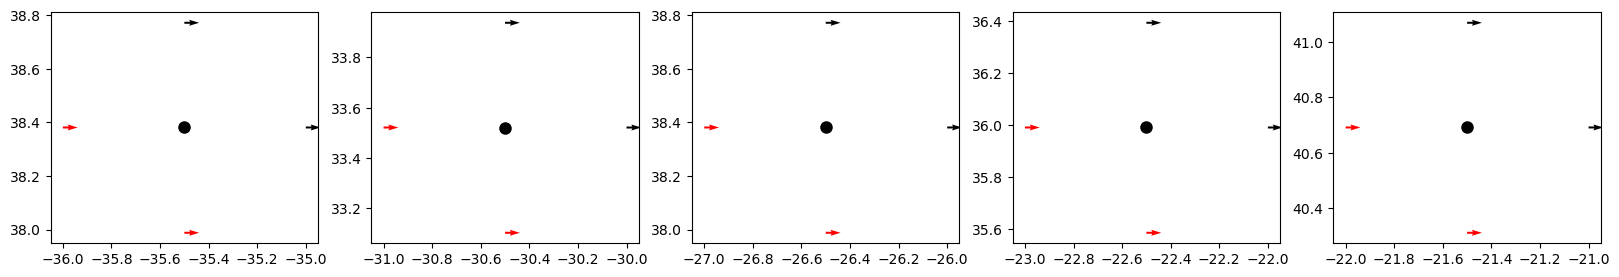

In [33]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(5, 10):
    ax1 = fig.add_subplot(gs[i-5])
    plt.plot(XCNA.isel(station=i).values, YCNA.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


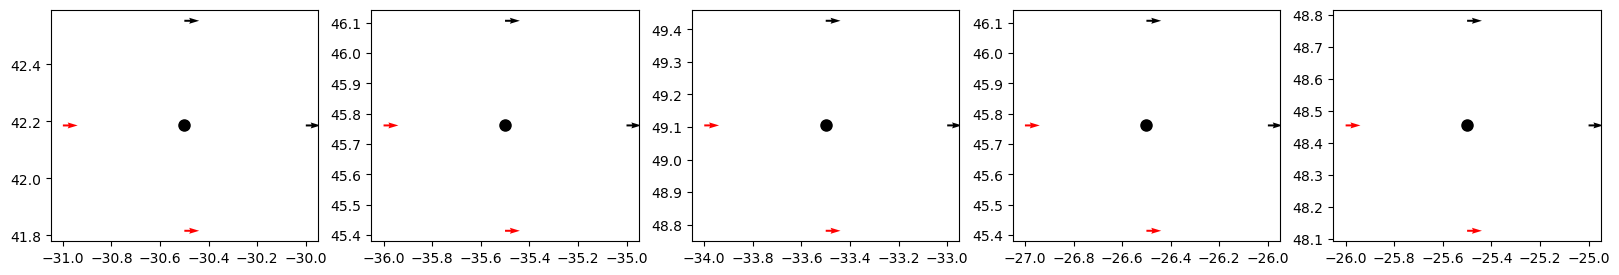

In [34]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(10, 15):
    ax1 = fig.add_subplot(gs[i-10])
    plt.plot(XCNA.isel(station=i).values, YCNA.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGNA.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCNA.isel(station=i), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCNA.isel(station=i), YGNA.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsNA._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsNA._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


In [35]:
XCC, YCC = od_stnsC._ds.XC, od_stnsC._ds.YC
XGC, YGC = od_stnsC._ds.XG, od_stnsC._ds.YG

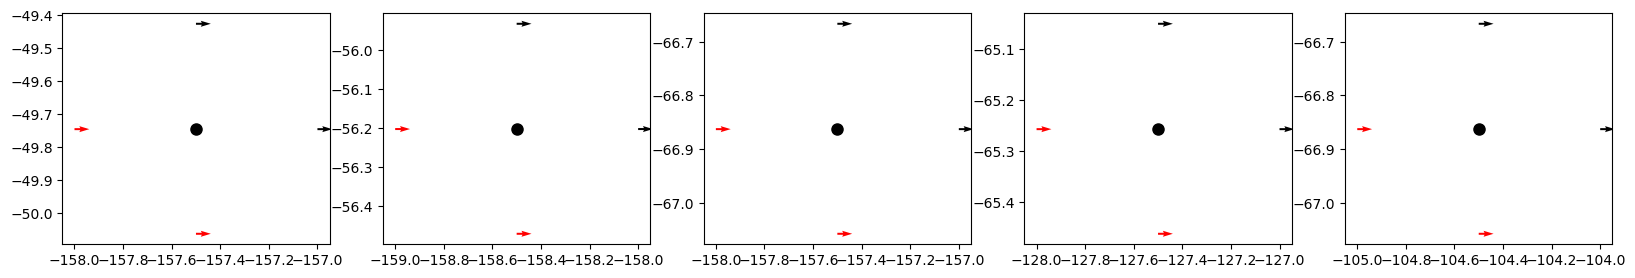

In [36]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(5):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


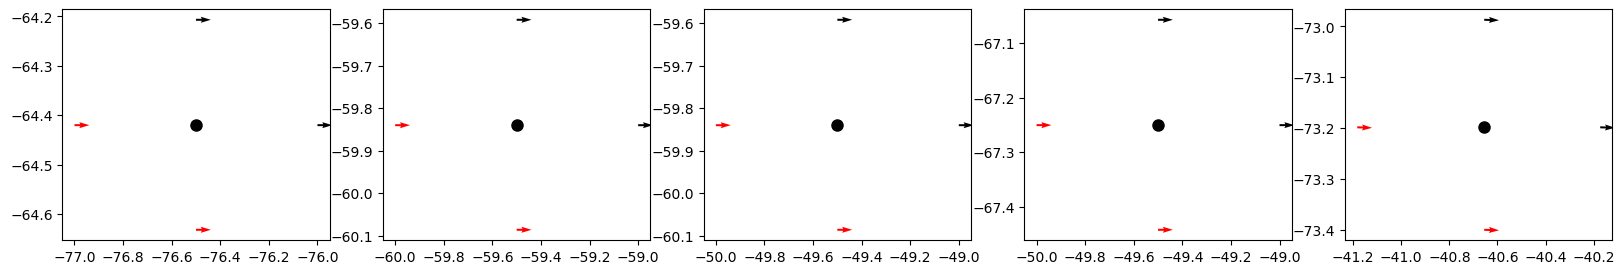

In [37]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(5, 10):
    ax1 = fig.add_subplot(gs[i-5])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


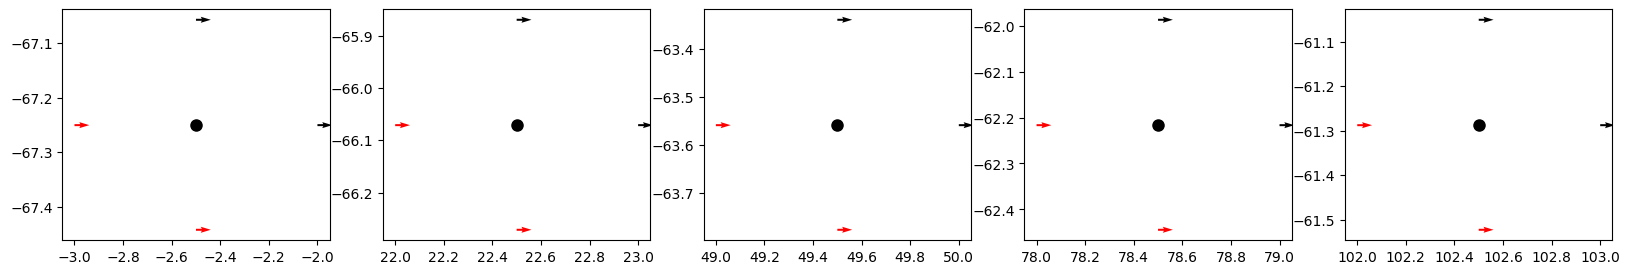

In [38]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(10, 15):
    ax1 = fig.add_subplot(gs[i-10])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


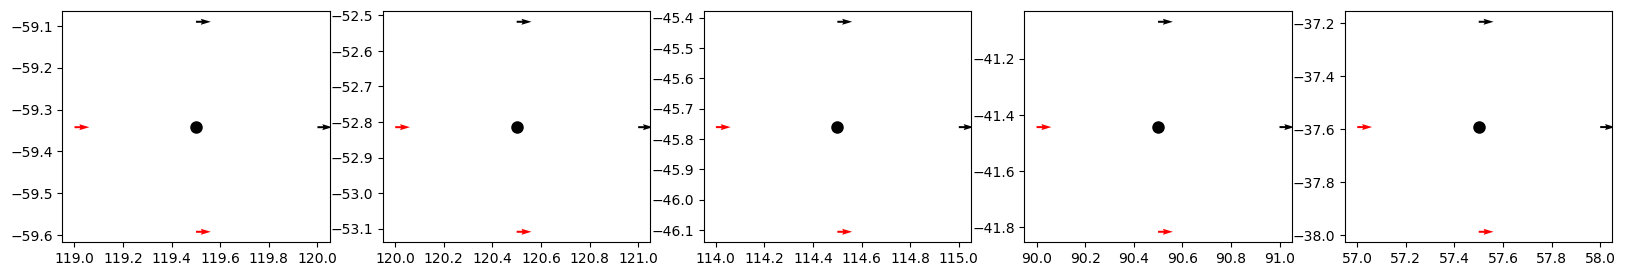

In [39]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(15, 20):
    ax1 = fig.add_subplot(gs[i-15])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


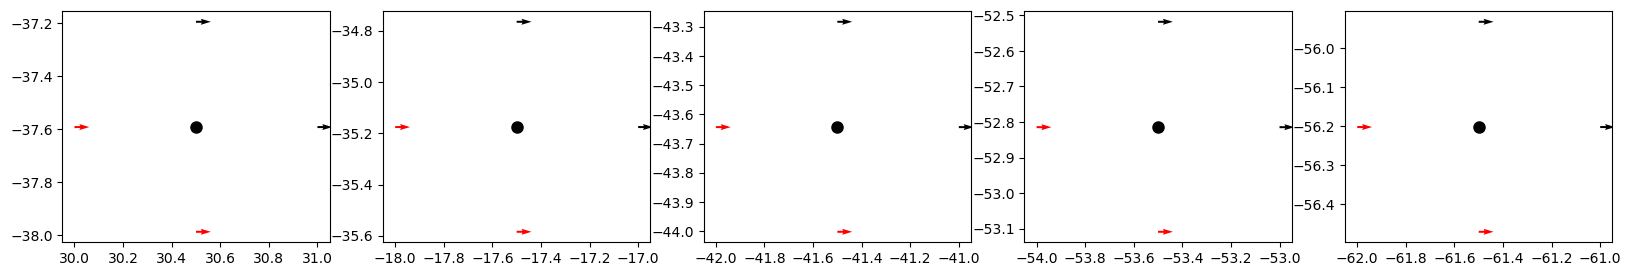

In [40]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(20, 25):
    ax1 = fig.add_subplot(gs[i-20])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


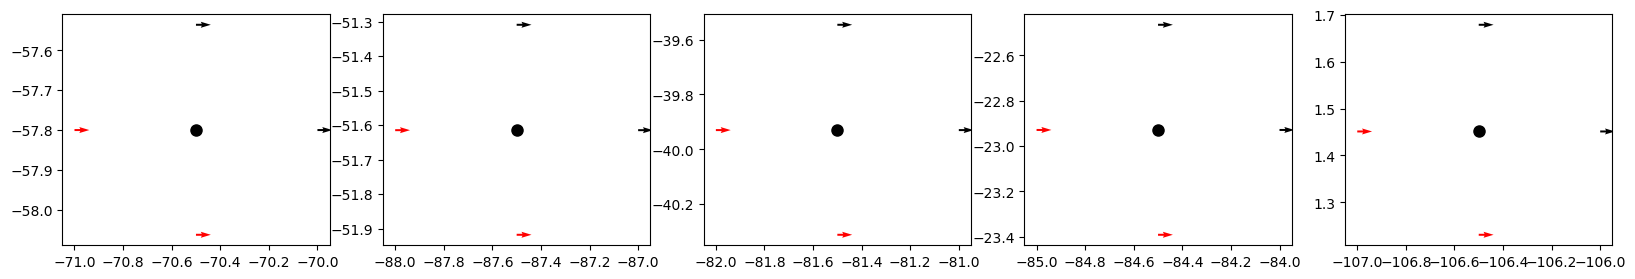

In [41]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 5)
for i in range(25, 30):
    ax1 = fig.add_subplot(gs[i-25])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


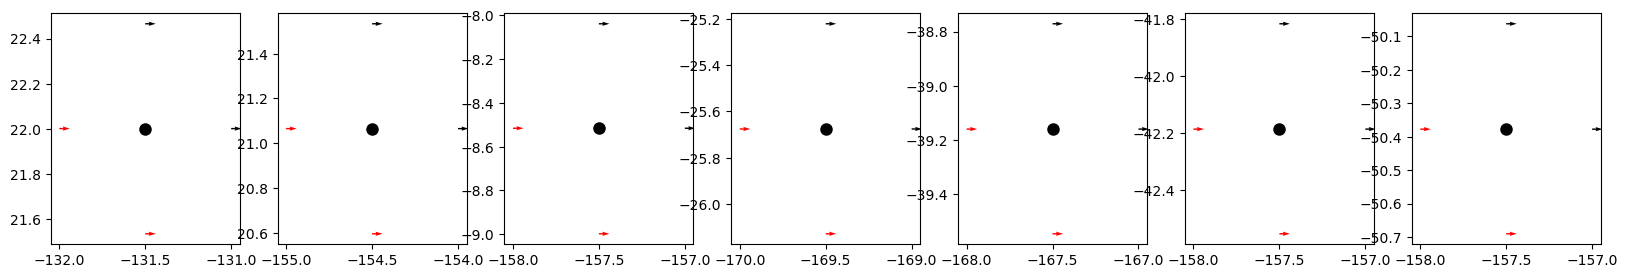

In [42]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, { 'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, 7)
for i in range(30, 37):
    ax1 = fig.add_subplot(gs[i-30])
    plt.plot(XCC.isel(station=i).values, YCC.isel(station=i), 'k', ls='',  marker='o',  markersize=8)
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XGC.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YCC.isel(station=i), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XCC.isel(station=i), YGC.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stnsC._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stnsC._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


# New coordinates

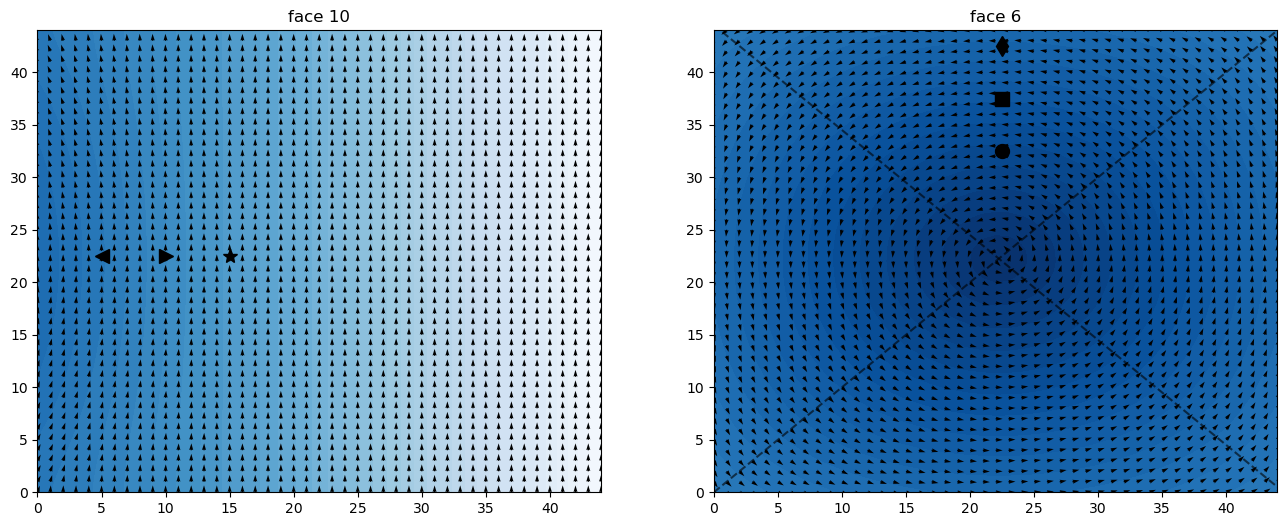

In [43]:
markers_new = ['*', '>', '<','d','s','o', ]

fig = plt.figure(figsize=(16, 6), facecolor='w')
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0])
plt.contourf(od._ds['YC'].isel(face=10)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=10)[::2, ::2], od._ds['VVELMASS'].isel(face=10)[::2, ::2]);

plt.plot(30/2, 45/2, 'k', marker='*', markersize=10);
plt.plot(20/2, 45/2, 'k', marker='>', markersize=10);
plt.plot(10/2, 45/2, 'k', marker='<', markersize=10);
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.title('face 10')
ax2 = fig.add_subplot(gs[1])
plt.contourf(od._ds['YC'].isel(face=6)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=6)[::2, ::2], od._ds['VVELMASS'].isel(face=6)[::2, ::2]);
plt.plot(np.linspace(0, 44.5, 10), np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 44.5, 10), 44.5-np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(45/2, 85/2, 'k', marker='d', markersize=10);
plt.plot(45/2, 75/2, 'k', marker='s', markersize=10);
plt.plot(45/2, 65/2, 'k', marker='o', markersize=10);
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.title('face 6');

In [44]:
args_90E = {
    "Ycoords": lats_6E, 
    "Xcoords": -87.5*np.ones(np.shape(lats_6E)),
}
od_stns90E = od.subsample.stations(**args_90E)

Extracting stations.


In [45]:
XC90E, YC90E = od_stns90E._ds.XC, od_stns90E._ds.YC
XG90E, YG90E = od_stns90E._ds.XG, od_stns90E._ds.YG

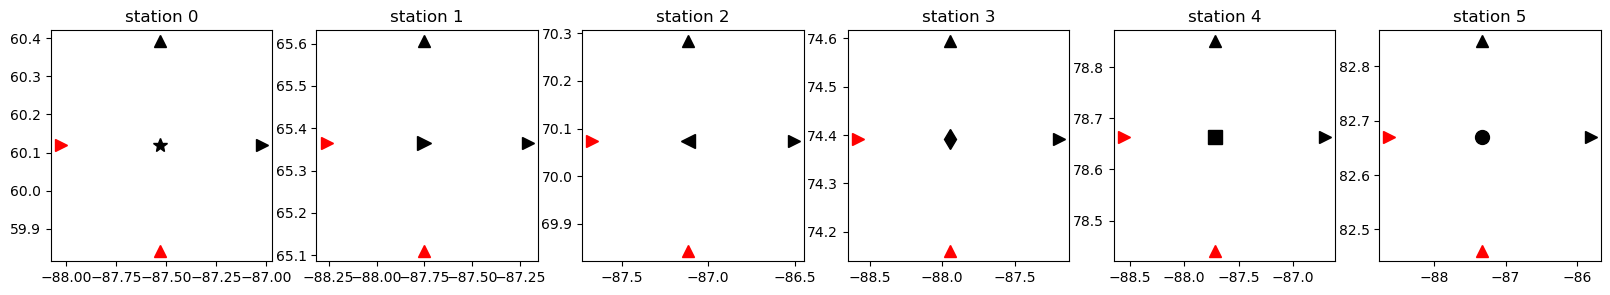

In [46]:
# point 5
fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC90E))
for i in range(len(XC90E)):
    ax = fig.add_subplot(gs[i])
    plt.plot(XC90E.isel(station=i).values, YC90E.isel(station=i), 'k', ls='',  marker=markers_new[i], markersize=10)
    plt.plot(XG90E.isel(station=i, Xp1=0, Yp1=0), YC90E.isel(station=i), 'r', ls='',marker='>', markersize=8)
    plt.plot(XG90E.isel(station=i, Xp1=1, Yp1=0), YC90E.isel(station=i), 'k',ls='',marker='>', markersize=8)
    plt.plot(XC90E.isel(station=i), YG90E.isel(station=i,Xp1=0, Yp1=0), 'r',ls='',marker='^', markersize=8)
    plt.plot(XC90E.isel(station=i), YG90E.isel(station=i,Xp1=0, Yp1=1), 'k',ls='',marker='^', markersize=8)
    plt.title('station '+str(i))
plt.show()

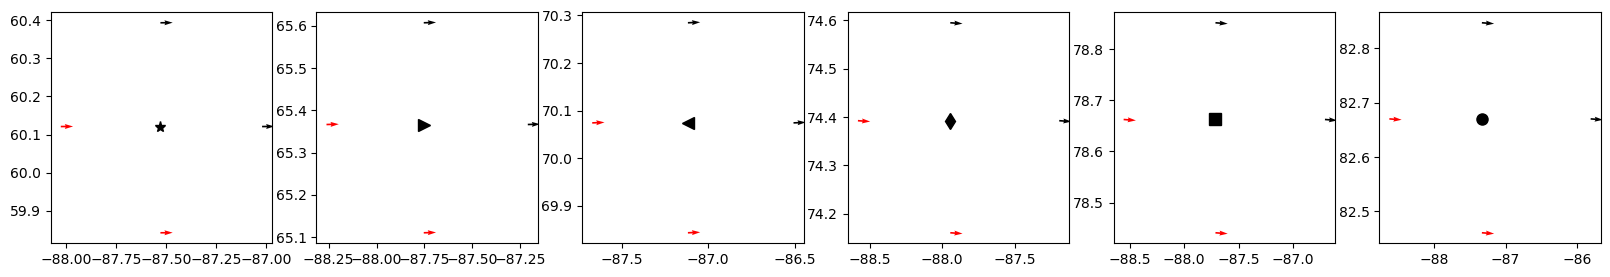

In [47]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, {'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC90E))
for i in range(len(XC90E.squeeze())):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XC90E.isel(station=i).values, YC90E.isel(station=i), 'k', ls='',  marker=markers_new[i],  markersize=8)
    plt.quiver(XG90E.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YC90E.isel(station=i), od_stns90E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns90E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XG90E.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YC90E.isel(station=i), od_stns90E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns90E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XC90E.isel(station=i), YG90E.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stns90E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns90E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XC90E.isel(station=i), YG90E.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stns90E._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns90E._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')


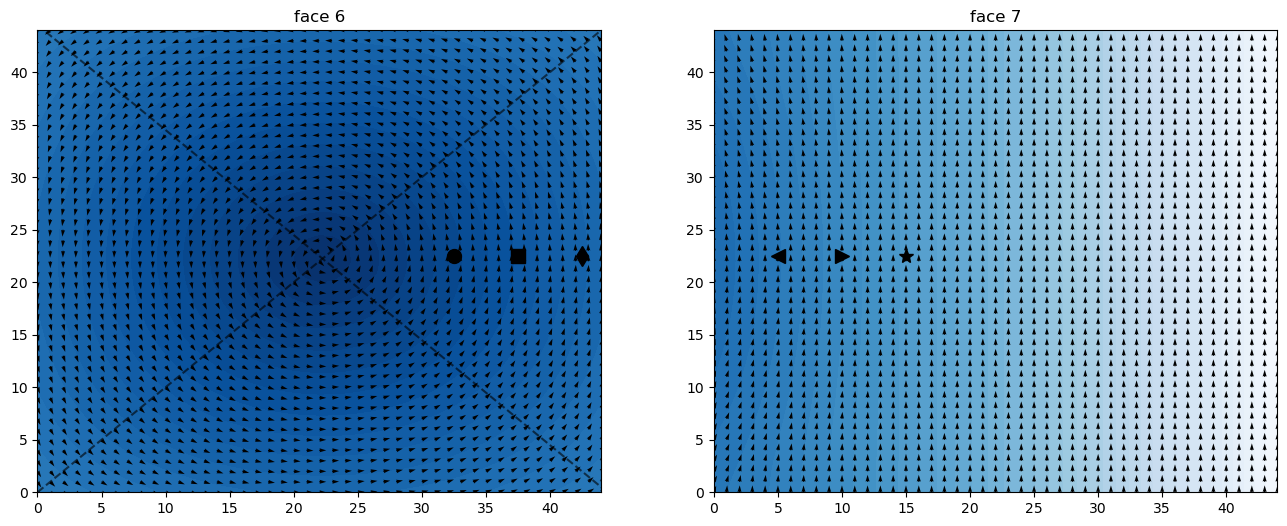

In [48]:
markers_new = ['*', '>', '<','d','s','o', ]

fig = plt.figure(figsize=(16, 6), facecolor='w')
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[1])
plt.contourf(od._ds['YC'].isel(face=7)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=7)[::2, ::2], od._ds['VVELMASS'].isel(face=10)[::2, ::2]);

plt.plot(30/2, 45/2, 'k', marker='*', markersize=10);
plt.plot(20/2, 45/2, 'k', marker='>', markersize=10);
plt.plot(10/2, 45/2, 'k', marker='<', markersize=10);
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.title('face 7')
ax2 = fig.add_subplot(gs[0])
plt.contourf(od._ds['YC'].isel(face=6)[::2, ::2], levels=np.linspace(10, 90, 50), cmap='Blues')
plt.quiver(od._ds['UVELMASS'].isel(face=6)[::2, ::2], od._ds['VVELMASS'].isel(face=6)[::2, ::2]);
plt.plot(np.linspace(0, 44.5, 10), np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(np.linspace(0, 44.5, 10), 44.5-np.linspace(0, 44.5, 10), 'k--', alpha=0.6)
plt.plot(85/2, 45/2, 'k', marker='d', markersize=10);
plt.plot(75/2, 45/2, 'k', marker='s', markersize=10);
plt.plot(65/2, 45/2, 'k', marker='o', markersize=10);
plt.xlim(0, 44)
plt.ylim(0, 44)
plt.title('face 6');

In [49]:
args_160W = {
    "Ycoords": lats_6E, 
    "Xcoords": -170*np.ones(np.shape(lats_6E)),
}

od_stns160W = od.subsample.stations(**args_160W)

Extracting stations.


In [50]:
XC160W, YC160W = od_stns160W._ds.XC, od_stns160W._ds.YC
XG160W, YG160W = od_stns160W._ds.XG, od_stns160W._ds.YG

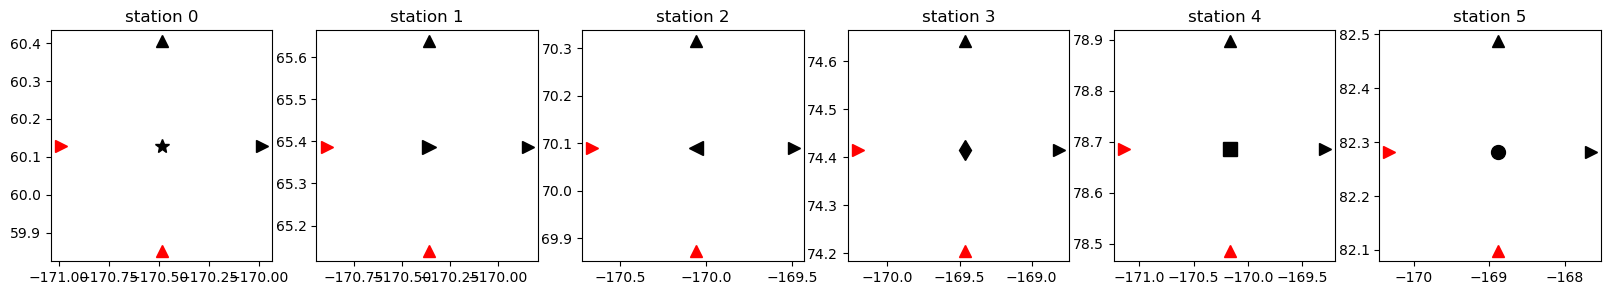

In [51]:
# point 5
fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC160W))
for i in range(len(XC160W)):
    ax = fig.add_subplot(gs[i])
    plt.plot(XC160W.isel(station=i).values, YC160W.isel(station=i), 'k', ls='',  marker=markers_new[i], markersize=10)
    plt.plot(XG160W.isel(station=i, Xp1=0, Yp1=0), YC160W.isel(station=i), 'r', ls='',marker='>', markersize=8)
    plt.plot(XG160W.isel(station=i, Xp1=1, Yp1=0), YC160W.isel(station=i), 'k',ls='',marker='>', markersize=8)
    plt.plot(XC160W.isel(station=i), YG160W.isel(station=i,Xp1=0, Yp1=0), 'r',ls='',marker='^', markersize=8)
    plt.plot(XC160W.isel(station=i), YG160W.isel(station=i,Xp1=0, Yp1=1), 'k',ls='',marker='^', markersize=8)
    plt.title('station '+str(i))
plt.show()

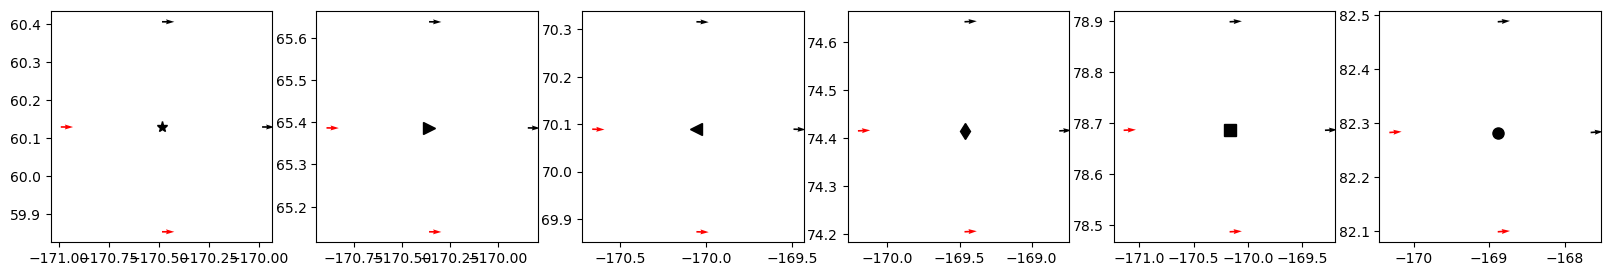

In [52]:
argsu0, argsu1 = {'Xp1': 0}, {'Xp1': 1}
argsv0, argsv1 = {'Yp1':0}, {'Yp1':1}

fig = plt.figure(figsize=(20, 3), facecolor='w')
gs = fig.add_gridspec(1, len(XC160W))
for i in range(len(XC160W.squeeze())):
    ax1 = fig.add_subplot(gs[i])
    plt.plot(XC160W.isel(station=i).values, YC160W.isel(station=i), 'k', ls='',  marker=markers_new[i],  markersize=8)
    plt.quiver(XG160W.isel(**{**{'station':i, 'Yp1':0}, **argsu0}), YC160W.isel(station=i), od_stns160W._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns160W._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XG160W.isel(**{**{'station':i, 'Yp1':0}, **argsu1}), YC160W.isel(station=i), od_stns160W._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns160W._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}))
    plt.quiver(XC160W.isel(station=i), YG160W.isel(**{**{'station':i, 'Xp1':0}, **argsv0}), od_stns160W._ds['UVELMASS'].isel(**{**{'station':i}, **argsu0}), od_stns160W._ds['VVELMASS'].isel(**{**{'station':i}, **argsv0}), color='r')
    plt.quiver(XC160W.isel(station=i), YG160W.isel(**{**{'station':i, 'Xp1':0}, **argsv1}), od_stns160W._ds['UVELMASS'].isel(**{**{'station':i}, **argsu1}), od_stns160W._ds['VVELMASS'].isel(**{**{'station':i}, **argsv1}), color='k')
